In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def preprocess_health_data(data, z_threshold=3):
    # Make a copy to avoid modifying the original data
    df = data.copy()

    # Separate categorical and numerical columns
    categorical_cols = ['sex', 'DRK_YN', 'SMK_stat_type_cd', 'hear_left', 'hear_right']
    numerical_cols = [col for col in df.columns if col not in categorical_cols]
    outlier_detection_cols = [col for col in numerical_cols if col not in ['sight_left', 'sight_right']]


    # --- Handle categorical variables ---
    # convert 'sex' to binary
    df['sex'] = (df['sex'] == 'Male').astype(int)

    # convert 'DRK_YN' to binary
    df['DRK_YN'] = (df['DRK_YN'] == 'Y').astype(int)

    # convert 'SMK_stat_type_cd' to one-hot encoding
    smoking_dummies = pd.get_dummies(df['SMK_stat_type_cd'], prefix='smoking')
    df = pd.concat([df.drop('SMK_stat_type_cd', axis=1), smoking_dummies], axis=1)

    # convert 'hear_left' and 'hear_right' to binary
    df['hear_left'] = (df['hear_left'] == 1.0).astype(int)
    df['hear_right'] = (df['hear_right'] == 1.0).astype(int)

    # --- Scale numerical features ---
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # boxplot of numerical features
    plot_boxplots_for_features(df[outlier_detection_cols])

    # --- Detect outliers using Z-score ---
    z_scores = np.abs(df[outlier_detection_cols].apply(lambda x: (x - x.mean()) / x.std()))
    outliers = df[(z_scores > z_threshold).any(axis=1)]

    # Remove the outliers from the preprocessed DataFrame
    df = df[~((z_scores > z_threshold).any(axis=1))]
    plot_boxplots_for_features(df[outlier_detection_cols])

    # Return preprocessed data and outliers
    return df, outliers

In [11]:
def plot_boxplots_for_features(df, figsize=(15, 10)):
    # Number of features
    num_features = df.shape[1]
    
    # Calculate the number of rows needed (3 plots per row)
    num_rows = int(np.ceil(num_features / 3))
    
    # Set up the figure
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array of axes to make iteration easier

    # Loop through each feature and create a boxplot
    for i, feature in enumerate(df.columns):
        sns.boxplot(x=df[feature], ax=axes[i])
        axes[i].set_title(f'Boxplot of {feature}')
        axes[i].set_xlabel('')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Reading Data...
Preprocessing Data...


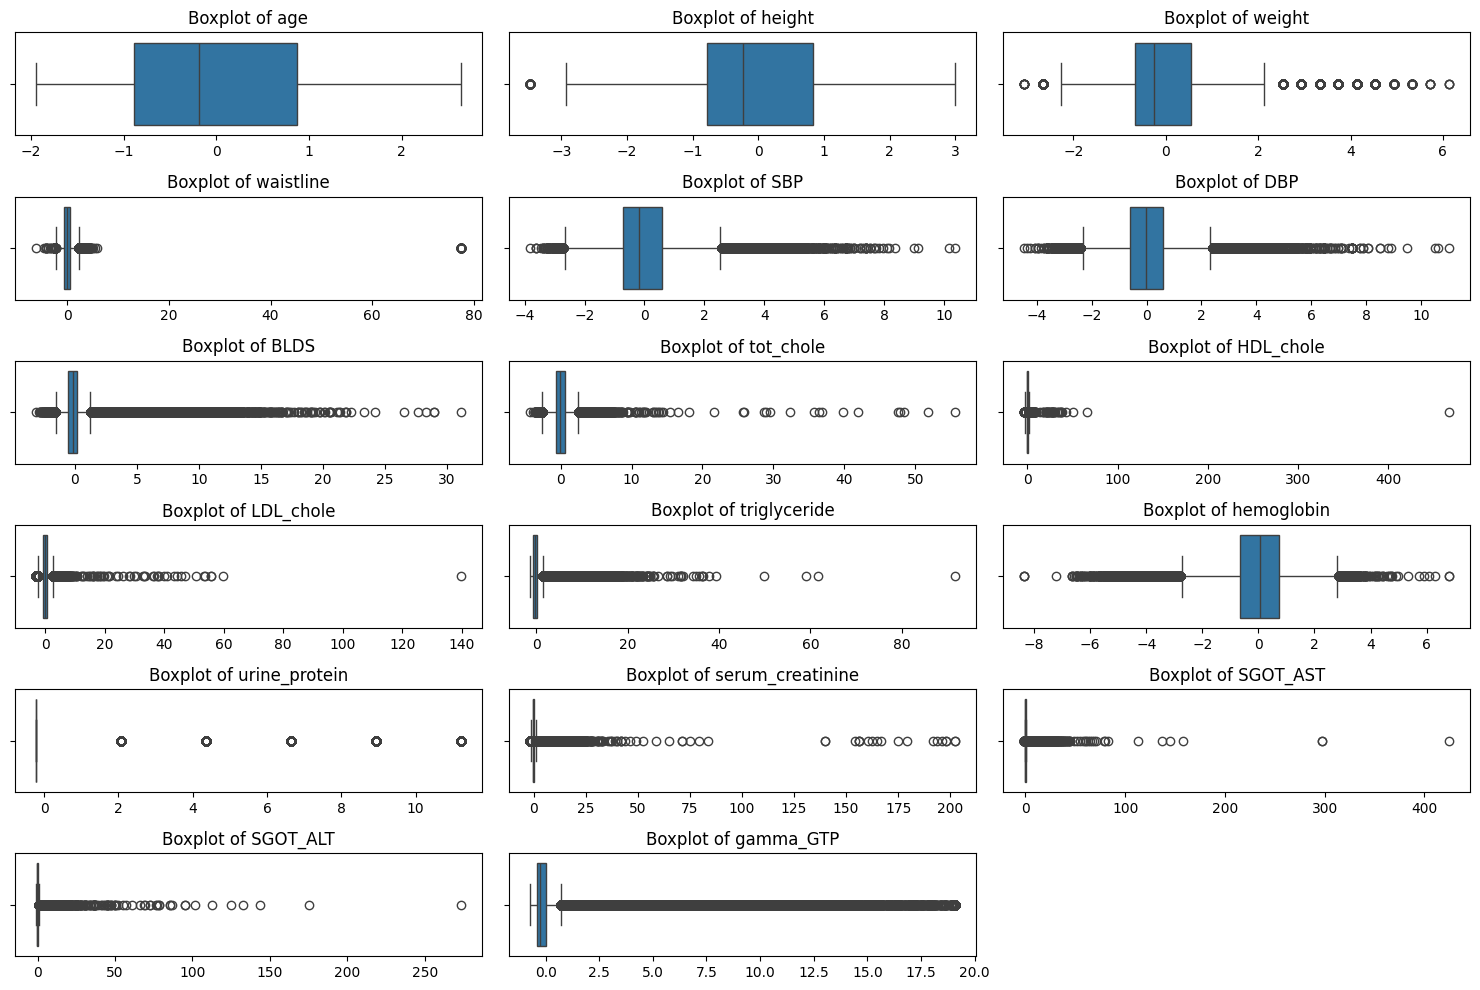

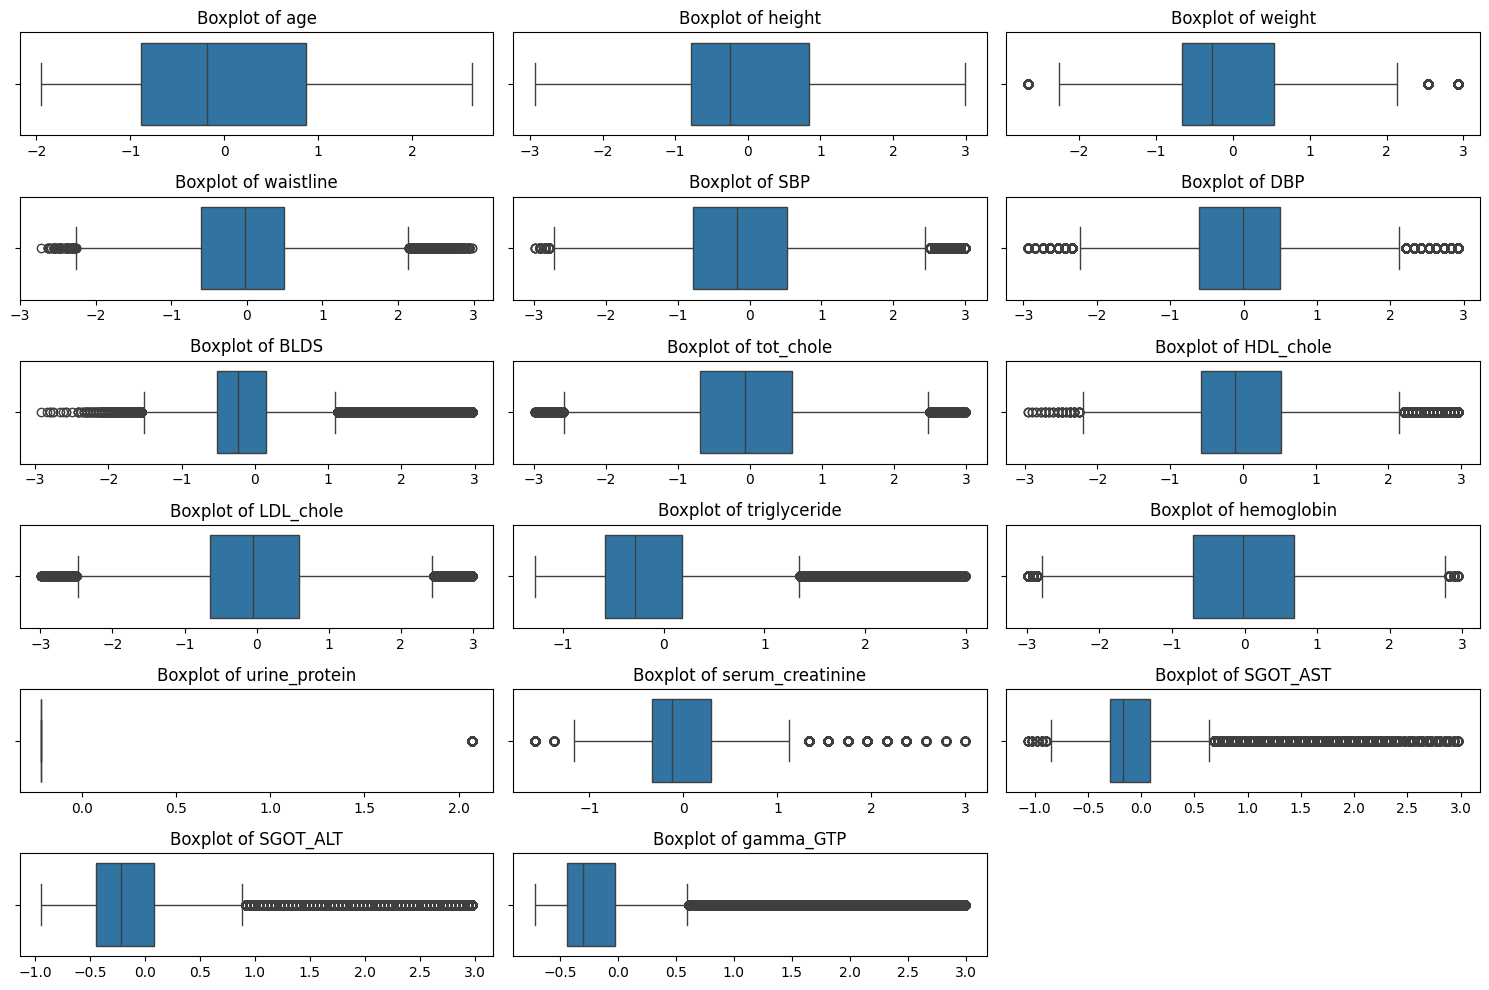

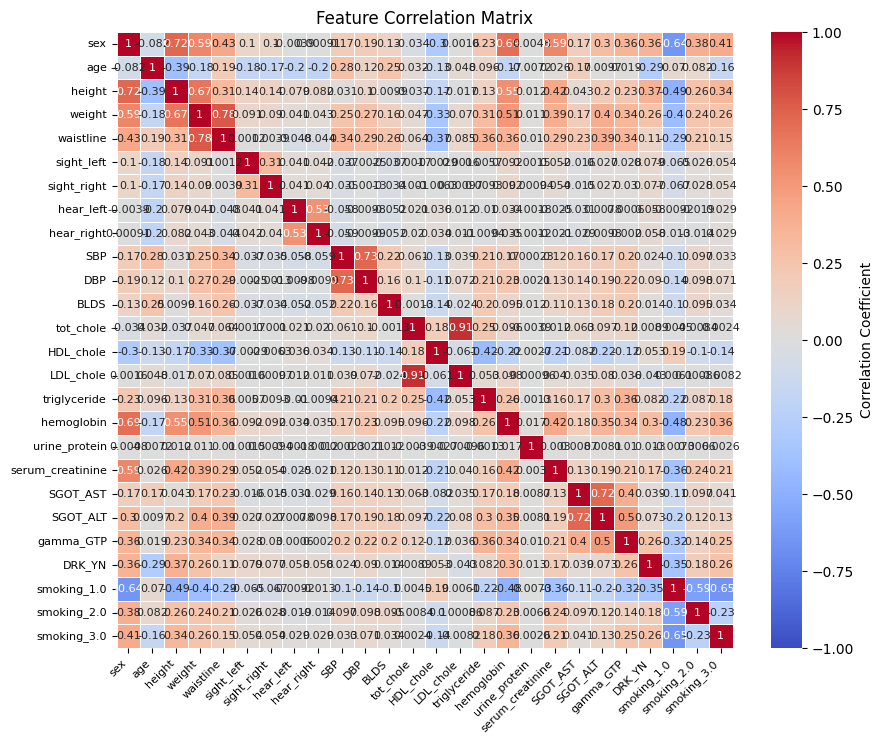


Preprocessed data saved to 'health_data_preprocessed.csv


In [12]:
# Example usage:
# Assuming your data is in a pandas DataFrame called 'health_data'
# First run without specifying n_components to analyze all components

print("Reading Data...")
df = pd.read_csv("data/smoking_driking_dataset_Ver01.csv")

z_treshold = 3

# Preprocess the data
print("Preprocessing Data...")
preprocessed_df, outliers = preprocess_health_data(df, z_threshold=z_treshold)

# Correlation matrix
correlation_matrix = preprocessed_df.corr()
plt.figure(figsize=(10, 8))
# Create a heatmap with the correlation matrix
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Display correlation coefficients
    cmap='coolwarm',  # Color map for better visual differentiation
    vmin=-1, vmax=1,  # Range for correlation values
    annot_kws={'size': 8},  # Adjust font size for the annotations
    linewidths=0.5,  # Add spacing between cells
    linecolor='white',  # Color of the gridlines
    square=True,  # Make the plot square-shaped for better readability
    cbar_kws={'label': 'Correlation Coefficient'}
)

# Adjust the font size of the labels
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=8, rotation=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Save preprocessed data
preprocessed_df.to_csv('health_data_preprocessed.csv', index=False)
print(f"\nPreprocessed data saved to 'health_data_preprocessed.csv")
